In [1]:
import numpy as np
from matplotlib import pyplot
import threading
import pickle
import argparse
import logging
import os
import random
import pprint
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow import keras
from tqdm import tqdm 
from tensorflow.keras import layers

In [2]:
with open("points.pickle",'rb') as pf:
    data = pickle.load(pf)
print(data[1])

[(14, 8), (17, 7), (20, 20), (14, 5), (18, 7), (2, 9), (21, 21), (21, 22), (19, 19), (21, 20)]


6.714408602150538


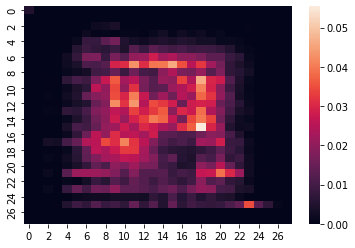

In [3]:
board = [[0 for _ in range(28)] for _ in range(28)]
for k,v in data.items():
    v = list(set(v))
    for x,y in v:
        board[x][y] += 1/len(data)

data = {k:v for k,v in data.items() if len(list(set(v)))>0}

df = pd.DataFrame(np.array(board).reshape(28,28))
p1 = sns.heatmap(df)

points_sum = 0
for k,v in data.items():
    v = list(set(v))
    points_sum += len(v)
print(points_sum/len(data))

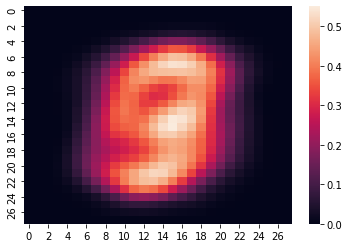

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_processed = x_train.astype("float32") / 255 / len(data)
num_board = np.array([[0 for _ in range(28)] for _ in range(28)]).astype(np.float32)
for k,v in data.items():
    num_board = np.add(x_processed[k], num_board)
df = pd.DataFrame(np.array(num_board).reshape(28,28))
p1 = sns.heatmap(df)

{0: 699, 1: 797, 2: 682, 3: 694, 4: 697, 5: 606, 6: 680, 7: 743, 8: 654, 9: 723}


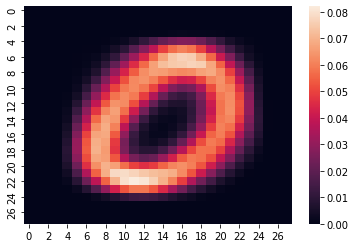

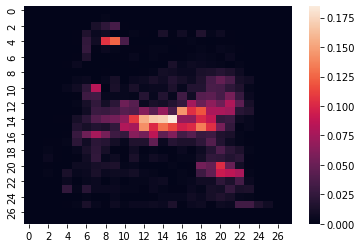

In [5]:
modified = [[[0 for _ in range(28)] for _ in range(28)] for _ in range(10)]
original = [pd.DataFrame(np.array([[0 for _ in range(28)] for _ in range(28)]).reshape(28,28)) for _ in range(10)]
numer_stat = {i:0 for i in range(10)}
for k,v in data.items():
    numer_stat[y_train[k]] += 1

print(numer_stat)

for k,v in data.items():
    v = list(set(v))
    number = y_train[k]
    for x,y in v:
        modified[number][x][y] += 1/numer_stat[number]
    original[number] = np.add(original[number], x_processed[k])
    

for i in range(1):
    sns.heatmap(pd.DataFrame(original[i]))
    pyplot.show()
    sns.heatmap(pd.DataFrame(modified[i]))
    pyplot.show()


In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

slice_points = 7
input_shape = (28, 28, 1)
output_shape = (5,2,28)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

ad_x = []
ad_y  = []
for k,v in data.items():
    v = list(set(v))
    ad_x.append(x_train[k])
    v = v*slice_points
    arr = np.zeros(shape=(28,28), dtype=float)
    for i in range(slice_points):
        arr[v[i][0]][v[i][1]] = 1
    ad_y.append(arr)

ad_x = np.expand_dims(ad_x, -1)
ad_y = np.array(ad_y)
ad_y = np.expand_dims(ad_y, -1)


print(ad_x.shape)
print(ad_y.shape)

admodel = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(28*28*1),
        layers.Reshape((28, 28, 1)),
    ]
)

print("Model output", admodel.output_shape)
admodel.summary()

# """
# ## Train the model
# """

batch_size = 128
epochs = 5

admodel.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])
admodel.fit(ad_x, ad_y, batch_size=batch_size, epochs=epochs, validation_split=0.2)



(6975, 28, 28, 1)
(6975, 28, 28, 1)
Model output (None, 28, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 784)               3613456   
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         

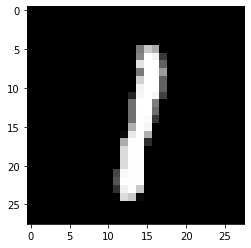

<AxesSubplot:>

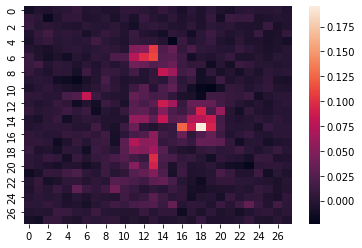

In [7]:
# admodel.save('admnist.h5')
admodel = keras.models.load_model('admnist.h5')
pyplot.imshow(x_train[1200], cmap=pyplot.get_cmap('gray'))
pyplot.show()
predictions = admodel.predict(np.expand_dims(x_train[1200], axis=0))[0]
sns.heatmap(pd.DataFrame(predictions.reshape(28,28), index=[i for i in range(28)], columns=[i for i in range(28)]))

In [8]:
multiply_factors = [] 
model = keras.models.load_model('mnist.h5')
model.summary()
for sample_num in range(10):
    attack = admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28)
    attacked_image = x_train[sample_num]
    for multiply_factor in range(1,500):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1
        # print(model.predict(np.expand_dims(attacked_image, axis=0))[0][y_train[sample_num]])
        if model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax() != model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            multiply_factors.append(multiply_factor)
            print(multiply_factor, end=",")
            # file_to_store = open(f"multiply_factors.pickle", "wb")
            # pickle.dump(multiply_factors, file_to_store)
            # file_to_store.close()
            break

# with open("multiply_factors.pickle",'rb') as pf:
#     multiply_factors = pickle.load(pf)
# print(sum(multiply_factors)/len(multiply_factors))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

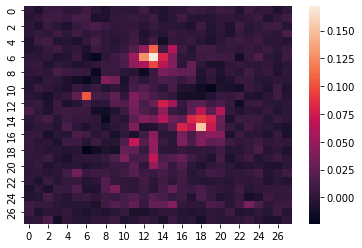

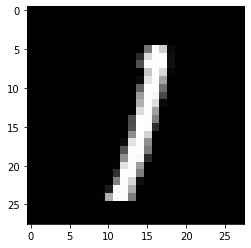

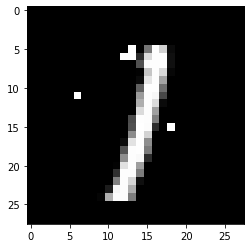

Original  1 Now  7 Multiply_factor 10


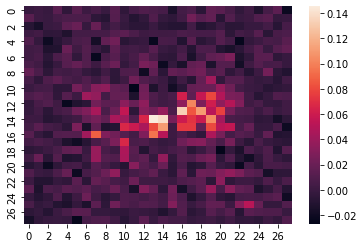

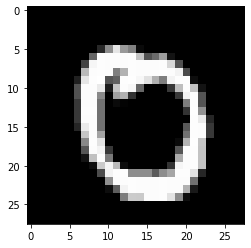

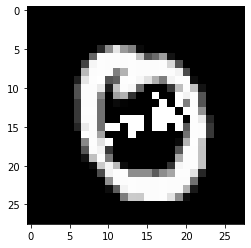

Original  0 Now  8 Multiply_factor 17


In [9]:
def adaptive_attack(sample_num):
    attack = admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28)
    attacked_image = x_train[sample_num]
    sns.heatmap(pd.DataFrame(admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28), index=[i for i in range(28)], columns=[i for i in range(28)]))
    pyplot.show()
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1
        if model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            pyplot.imshow(x_train[sample_num], cmap=pyplot.get_cmap('gray'))
            pyplot.show()
            pyplot.imshow(attacked_image, cmap=pyplot.get_cmap('gray'))
            pyplot.show()
            print("Original ", model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax(), "Now ", model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax(), "Multiply_factor", multiply_factor)
            return
    print("multiply_factor reached 300, can't trigger attack")

for i in range(2):
    adaptive_attack(random.randint(0, 60000))


In [10]:
np.set_printoptions(suppress=False)
model = keras.models.load_model('mnist.h5')

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
y_train = [0 for _ in range(len(x_train))]
y_test = [0 for _ in range(len(x_test))]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
# for i in tqdm(range(len(x_train))):
#     y_train[i] = model.predict(np.expand_dims(x_train[i], axis=0))[0]
# for i in tqdm(range(len(x_test))):
#     y_test[i] = model.predict(np.expand_dims(x_train[i], axis=0))[0]
with open("y_test.pickle", 'rb') as f:
    y_test = pickle.load(f)
with open("y_train.pickle", 'rb') as f:
    y_train = pickle.load(f)
print(y_train[0])

model.predict(np.expand_dims(x_train[12], axis=0))[0]

[4.5048149e-11 3.5150799e-10 1.4140485e-08 8.7882634e-03 1.7847142e-12
 9.9120283e-01 6.1413509e-12 5.3239265e-08 7.3510769e-06 1.5585496e-06]


array([3.2421608e-13, 5.8164481e-13, 3.6874552e-09, 1.0000000e+00,
       5.4793237e-14, 2.4981477e-09, 4.1779832e-15, 2.8484762e-10,
       3.6039822e-08, 2.8229754e-09], dtype=float32)

In [11]:
# file_to_store = open(f"y_train.pickle", "wb")
# pickle.dump(y_train, file_to_store)
# file_to_store.close()
# file_to_store = open(f"y_test.pickle", "wb")
# pickle.dump(y_test, file_to_store)
# file_to_store.close()
with open("y_test.pickle", 'rb') as f:
    y_test = pickle.load(f)
with open("y_train.pickle", 'rb') as f:
    y_train = pickle.load(f)

In [12]:
y_train = np.array(y_train)
y_test = np.array(y_test)
dismodel = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10),
    ]
)

print("Model output", dismodel.output_shape)
dismodel.summary()

# """
# ## Train the model
# """

batch_size = 128
epochs = 5

dismodel.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])
dismodel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.5)
# dismodel.save('dismnist.h5')


Model output (None, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (

[9.9765623e-01 3.1846273e-13 3.8581383e-08 9.5038658e-08 1.9690918e-10
 2.3296350e-03 1.8430711e-06 3.5414327e-08 3.4324187e-06 8.7547969e-06]
[ 0.48065966 -0.01393684  0.00165986 -0.08657335 -0.11293082  0.19660023
  0.2097409   0.14513147  0.01615984  0.13439207]


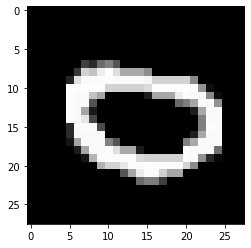

[1.2120165e-06 1.6364855e-03 4.6216692e-06 6.2830904e-06 1.0937656e-03
 1.6273342e-06 3.3047520e-11 9.8738599e-01 1.1638171e-05 9.8584564e-03]
[ 0.05392544  0.04926949 -0.06502758 -0.003021    0.12423255  0.02973137
 -0.01993525  0.6503422   0.00909254  0.16347924]


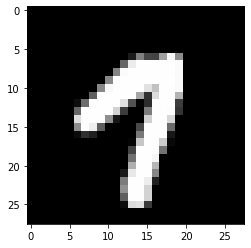

[1.9723364e-08 7.8690743e-13 1.1178100e-10 3.1183296e-11 1.6571383e-06
 1.1498834e-06 9.9999690e-01 8.7392175e-15 2.1433236e-07 6.5409388e-12]
[-0.03081039 -0.00175275 -0.03267208 -0.09320061  0.06665783  0.21845527
  1.0270412  -0.00413077 -0.06084927 -0.07097219]


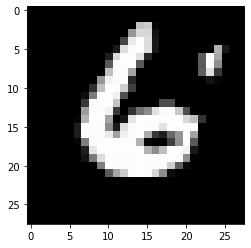

In [13]:
for i in range(3):
    sample_num = random.randint(0, 60000)
    print(model.predict(np.expand_dims(x_train[sample_num], axis=0))[0])
    print(dismodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0])
    pyplot.imshow(x_train[sample_num], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

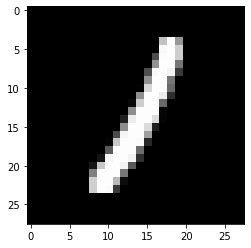

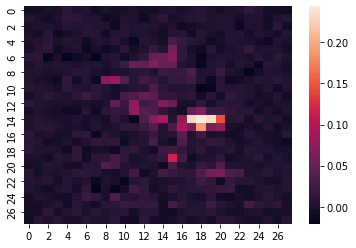

ValueError: in user code:

    File "c:\Users\yukim\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\yukim\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yukim\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\yukim\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Users\yukim\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\yukim\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 28, 28, 28)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 28, 28, 28), dtype=float32)
      • training=False
      • mask=None


In [14]:
def adaptive_attack_dis(sample_num):
    attack = admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28)
    attacked_image = x_train[sample_num]
    pyplot.imshow(x_train[sample_num], cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    sns.heatmap(pd.DataFrame(admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28), index=[i for i in range(28)], columns=[i for i in range(28)]))
    pyplot.show()
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1
        if model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            pyplot.imshow(attacked_image, cmap=pyplot.get_cmap('gray'))
            pyplot.show()
            print("Original ", model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax(), "Now ", model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax(), "Multiply_factor original model", multiply_factor)
            break
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1       
        if dismodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=dismodel.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            pyplot.imshow(attacked_image, cmap=pyplot.get_cmap('gray'))
            pyplot.show()
            print("Original ", model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax(), "Now ", model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax(), "Multiply_factor distillation model", multiply_factor)
            break

for i in range(3):
    adaptive_attack_dis(random.randint(0, 60000))

In [ ]:
original_model_factors = []
distillation_model_factors = []

for i in range(600):
    sample_num = random.randint(0, 60000)
    attack = admodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].reshape(28,28)
    attacked_image = x_train[sample_num]
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1
        if model.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=model.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            original_model_factors.append(multiply_factor)
            break
    for multiply_factor in range(1,300):
        attackcopy = attack*multiply_factor
        attack_santinized = attackcopy.astype(int)
        attacked_image = np.add(x_train[sample_num], attack_santinized)
        attacked_image[attacked_image>1] = 1       
        if dismodel.predict(np.expand_dims(x_train[sample_num], axis=0))[0].argmax()!=dismodel.predict(np.expand_dims(attacked_image, axis=0))[0].argmax():
            distillation_model_factors.append(multiply_factor)
            break
    print( "Checking ", i,  "original model factor:", int(sum(original_model_factors)/len(original_model_factors)), "distillation model factor:" ,
            int(sum(distillation_model_factors)/len(distillation_model_factors)), end="           \r")